In [73]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util

# Explanation
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

In [74]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [75]:
kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([np.cos(tilt_angle), 0, -np.sin(tilt_angle)])

beam_size_x = 10.  # um
beam_size_y = 10.  # um

nx = 40
ny = 40
nz = 100

dx = 0.3
dy = 3.
dz = 10.

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nx * dz / 2, nx * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [76]:
weight_pulse1 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=False)

Get get the weight assuming a flat X-ray profile


In [77]:
weight1_xy = np.sum(weight_pulse1, axis=-1)
weight1_xz = np.sum(weight_pulse1, axis=1)
weight1_yz = np.sum(weight_pulse1, axis=0)

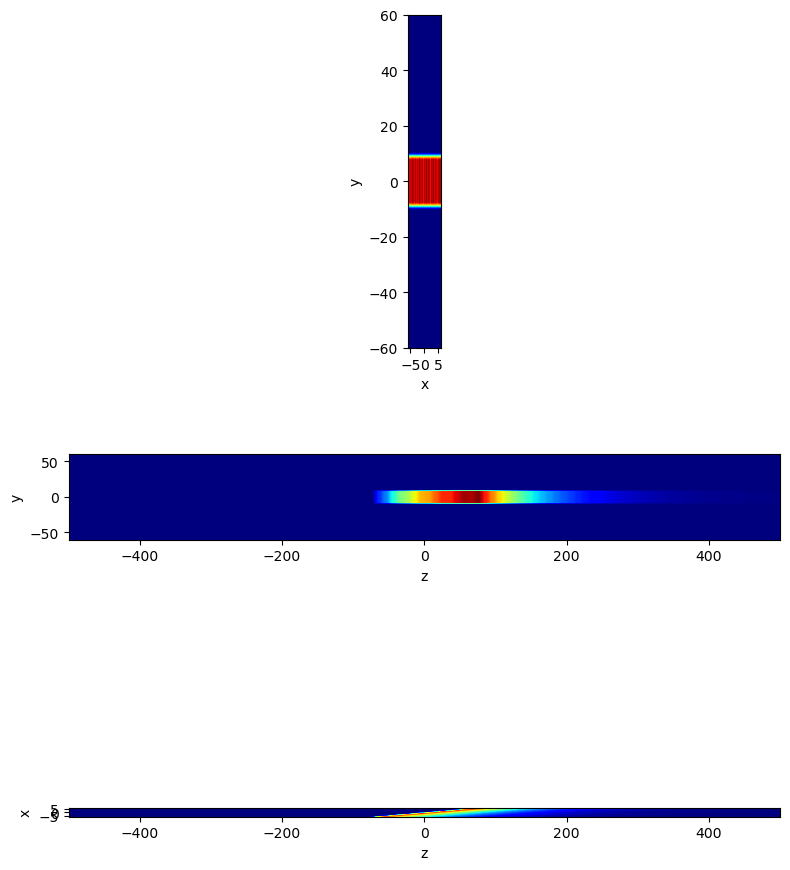

In [78]:
fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
axes[0].imshow(weight1_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].imshow(weight1_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

axes[2].imshow(weight1_xz[::-1,], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

Get get the weight assuming a Gaussian X-ray profile


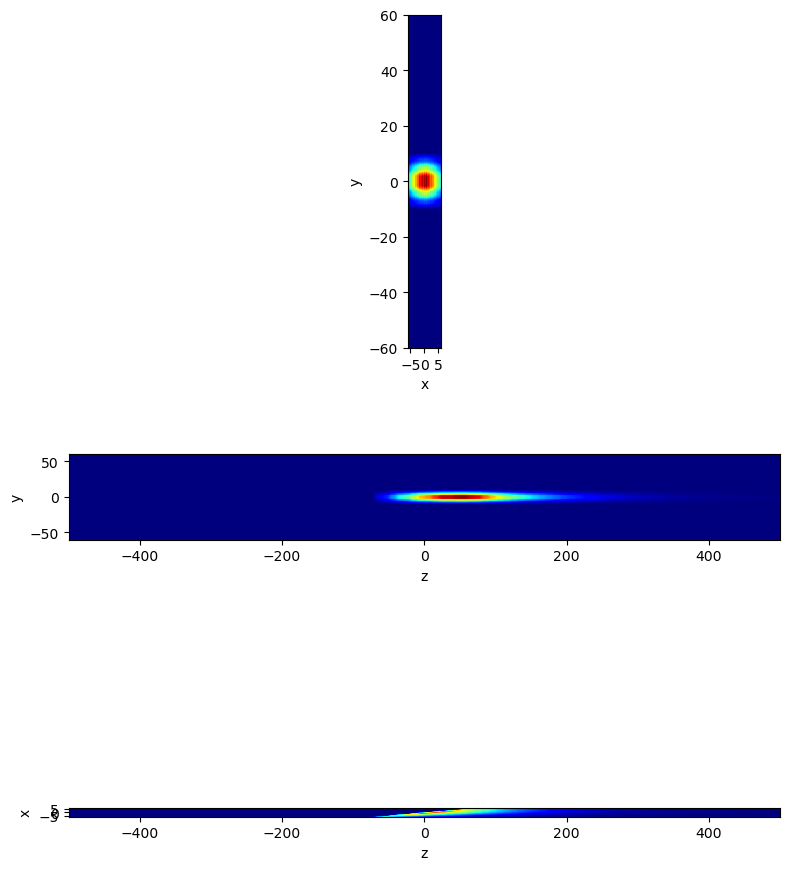

In [79]:
weight_pulse1 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)

weight1_xy = np.sum(weight_pulse1, axis=-1)
weight1_xz = np.sum(weight_pulse1, axis=1)
weight1_yz = np.sum(weight_pulse1, axis=0)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
axes[0].imshow(weight1_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].imshow(weight1_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

axes[2].imshow(weight1_xz[::-1,], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

Get get the weight assuming a Gaussian X-ray profile


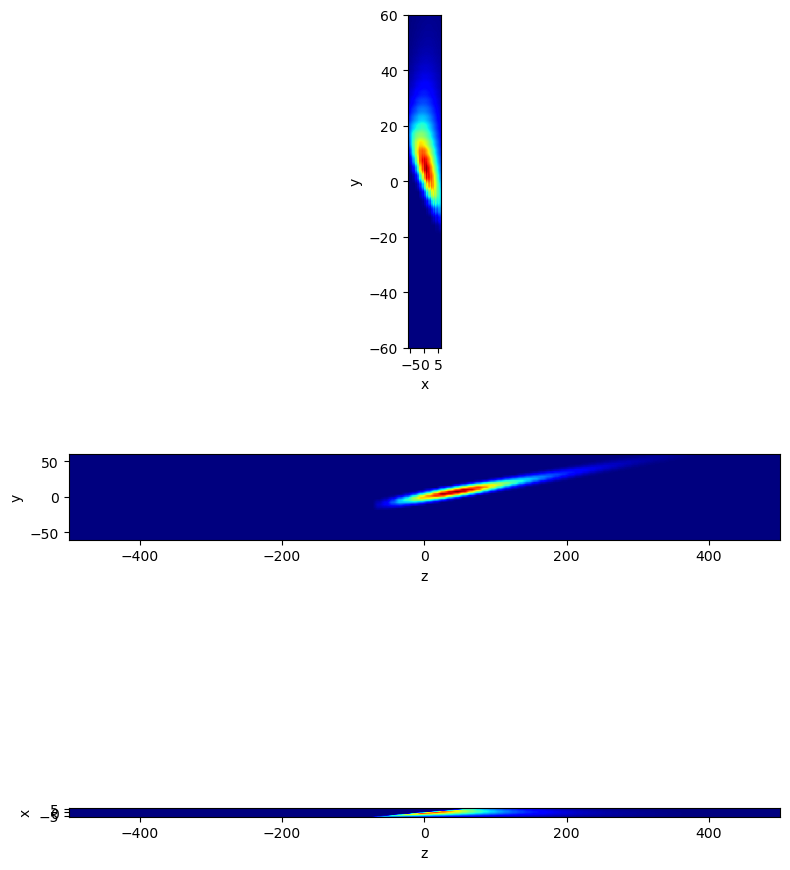

In [80]:
weight_pulse2 = add_weight_cylinder(start=np.zeros(3),
                                    direction=kin_direction,
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)

weight2_xy = np.sum(weight_pulse2, axis=-1)
weight2_xz = np.sum(weight_pulse2, axis=1)
weight2_yz = np.sum(weight_pulse2, axis=0)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
axes[0].imshow(weight2_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].imshow(weight2_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

axes[2].imshow(weight2_xz[::-1,], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [81]:
np.rad2deg(np.arctan(kin_direction[1] / kin_direction[2]))

-22.9797581953213

In [82]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.zeros(3),
                                    direction=kin_direction,
                                    fwhm_xy=[10, 10],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
pump_weight = weight_pulse1 + weight_pulse2
probe_weight = weight_pulse3

total_weight = probe_weight + pump_weight

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


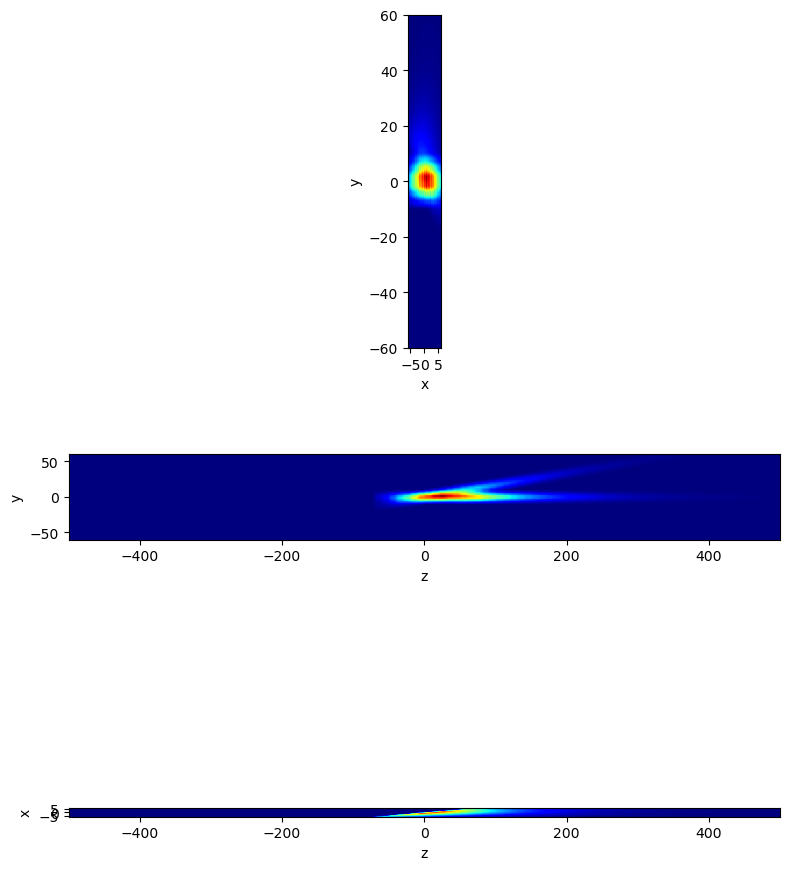

In [83]:
weight_xy = np.sum(total_weight, axis=-1)
weight_xz = np.sum(total_weight, axis=1)
weight_yz = np.sum(total_weight, axis=0)

fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_figheight(10)
fig.set_figwidth(8)
axes[0].imshow(weight_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

axes[2].imshow(weight_xz[::-1,], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()